In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import time
import matplotlib.pyplot as plt
import math
import torch.nn.init as init
import numpy as np



In [3]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]

In [4]:
class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [5]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [6]:
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}

In [7]:
def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [8]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


In [9]:
train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='data', train=True, transform=transform_train, download=True),
        batch_size=64, shuffle=True)

Files already downloaded and verified


In [10]:
test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='data', train=False, transform=transform_test),
        batch_size=64, shuffle=False)

In [11]:
learning_rate = 0.01

torch.manual_seed(2)
torch.cuda.manual_seed(2)
np.random.seed(2)

In [12]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 2 every 20 epochs"""
    lr = learning_rate * (0.5 ** (epoch // 20))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg = vgg19_bn()
optimizer = optim.SGD(vgg.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [14]:

# validation function
def validate(model, test_dataloader):
    model = model.to(device)
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)

        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()

    val_loss = val_running_loss / len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct / len(test_dataloader.dataset)

    return val_loss, val_accuracy

In [15]:

def fit(model, train_dataloader):
    
    model = model.to(device)
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss / len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct / len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')

    return train_loss, train_accuracy

In [16]:

print("BEGIN TRAINING")

train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

for epoch in range(25):
    adjust_learning_rate(optimizer, epoch)
    train_epoch_loss, train_epoch_accuracy = fit(vgg, train_loader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg, test_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()
print((end-start)/60, 'minutes')

torch.save(vgg.state_dict(), "model_cnn_vgg19bn_cifar10.pt")

print("done")

BEGIN TRAINING


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Loss: 0.0243, Train Acc: 41.77
Train Loss: 0.0159, Train Acc: 64.53
Train Loss: 0.0123, Train Acc: 73.47
Train Loss: 0.0098, Train Acc: 79.17
Train Loss: 0.0081, Train Acc: 83.22
Train Loss: 0.0066, Train Acc: 86.21
Train Loss: 0.0055, Train Acc: 88.57
Train Loss: 0.0045, Train Acc: 90.86
Train Loss: 0.0038, Train Acc: 92.26
Train Loss: 0.0030, Train Acc: 93.76
Train Loss: 0.0026, Train Acc: 94.70
Train Loss: 0.0021, Train Acc: 95.81
Train Loss: 0.0018, Train Acc: 96.27
Train Loss: 0.0015, Train Acc: 97.03
Train Loss: 0.0013, Train Acc: 97.32
Train Loss: 0.0012, Train Acc: 97.63
Train Loss: 0.0011, Train Acc: 97.70
Train Loss: 0.0009, Train Acc: 98.19
Train Loss: 0.0008, Train Acc: 98.38
Train Loss: 0.0008, Train Acc: 98.33
Train Loss: 0.0003, Train Acc: 99.50
Train Loss: 0.0001, Train Acc: 99.85
Train Loss: 0.0001, Train Acc: 99.83
Train Loss: 0.0000, Train Acc: 99.92
Train Loss: 0.0000, Train Acc: 99.94
34.501830605665845 minutes
done


In [17]:
torch.save(vgg.state_dict(), "/content/gdrive/MyDrive/model_cnn_vgg19bn_cifar10.pt")

validation error
0.1421


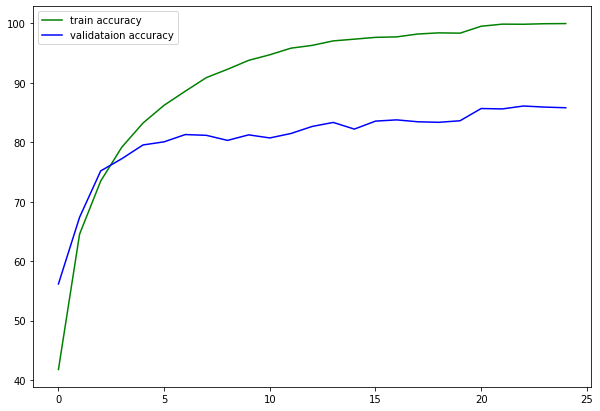

In [18]:

model_cnn = vgg19_bn()

model_cnn.load_state_dict(torch.load("model_cnn_vgg19bn_cifar10.pt"))
model_cnn.eval()
model_cnn = model_cnn.to(device)

total_loss, total_err = 0., 0.

for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    yp = model_cnn(X)

    total_err += (yp.max(dim=1)[1] != y).sum().item()

print("validation error")
print(total_err / len(test_loader.dataset))

plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()
